In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from scipy import stats
from tkinter import *
import pickle

from collections import Counter


import warnings
warnings.filterwarnings("ignore")


In [79]:
df = pd.read_csv("../../../data/kc_house_data.csv")

In [3]:
with open("ohe.pkl", "rb") as f:
    _ = pickle.load(f)

In [4]:
_.categories_[0]

array([98001., 98002., 98003., 98004., 98005., 98006., 98007., 98008.,
       98010., 98011., 98014., 98019., 98022., 98023., 98024., 98027.,
       98028., 98029., 98030., 98031., 98032., 98033., 98034., 98038.,
       98039., 98040., 98042., 98045., 98052., 98053., 98055., 98056.,
       98058., 98059., 98065., 98070., 98072., 98074., 98075., 98077.,
       98092., 98102., 98103., 98105., 98106., 98107., 98108., 98109.,
       98112., 98115., 98116., 98117., 98118., 98119., 98122., 98125.,
       98126., 98133., 98136., 98144., 98146., 98148., 98155., 98166.,
       98168., 98177., 98178., 98188., 98198., 98199.])

In [5]:
df.date

0        10/13/2014
1         12/9/2014
2         2/25/2015
3         12/9/2014
4         2/18/2015
            ...    
21592     5/21/2014
21593     2/23/2015
21594     6/23/2014
21595     1/16/2015
21596    10/15/2014
Name: date, Length: 21597, dtype: object

In [6]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

In [3]:
def model(x, target_df, standard=False, minmax=False, log=False):
    if log:
        #does log work on a bunh of columns at once?
#         x = np.log(x)
        target_df = np.log(target_df)
        
    #split data 
    X_train, X_test, y_train, y_test = train_test_split(x, target_df, random_state=42)
    
    #Implement scaler options if scaler parameters != None
    if minmax:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    if standard:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    #create model
    model = LinearRegression()
    #fit data to model
    model.fit(X_train, y_train)
    
    #Model coef
    df_column_names = x.columns
    coef = pd.DataFrame(list(zip(df_column_names, model.coef_)), columns = ["feature","weight"])\
    .sort_values("weight", ascending=False)
    
    #Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    if log:
        train_rmse = rmse(np.exp(train_pred), np.exp(y_train.values))
        test_rmse = rmse(np.exp(test_pred), np.exp(y_test.values))
    else:
    
        #train rmse
        train_rmse = rmse(train_pred, y_train.values)
        #test rmse
        test_rmse = rmse(test_pred, y_test.values)

    return ( round(train_rmse,2), round(test_rmse, 2), coef)

# Put best model in get prediction function

In [4]:
def get_prediction(x):
    #create model
    model = LinearRegression()
    #fit best feature df and target to model
    model.fit(all_df, target)
    
    #get prediction for x(user inputs) based off of fitted model
    pred = model.predict(x)
    return pred

In [6]:
def click():
    entries = []
    column_names = ["sqft_living", "grade", "sqft_above", "sqft_living15", "bathrooms", "bedrooms", "floors", "sqft_lot15", "sqft_lot", "zipcode", "age"]
    
    #saves text entry to entered_text variable when function is called by button press
    entries.append(sqft_living.get())
    entries.append(grade.get())
    entries.append(sqft_above.get())
    entries.append(sqft_living15.get())
    entries.append(bathrooms.get())
    entries.append(bedrooms.get())
    entries.append(floors.get())
    entries.append(sqft_lot15.get())
    entries.append(sqft_lot.get())
    entries.append(zipcode.get())
    entries.append(age.get())
    
    entries_df = pd.DataFrame([entries], columns= column_names)
    
    #one hot encode zip code column then drop it
    zip_code = entries_df[['zipcode']]
    onehot = OneHotEncoder(sparse=False)
    onehot_data = onehot.fit_transform(zip_code)
    zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
    entries_df = pd.concat([entries_df,zip_code],axis=1)
    
    print(entries_df)
#     ##Call model() function at end of this function to get output
#     predicted_price = get_prediction(entries_df)
    
#     if all(item != "" and is_number(item) for item in entries): 
#         #Clear output text box and output new word to it.
#         output.delete(0.0,END)
#         output.insert(END, predicted_price)
#     else:
#         output.delete(0.0,END)
#         output.insert(END, "Error: Missing or Invalid Entries")

In [8]:
def top_entries(df):
    #df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
    
    mat = df.corr().abs()
    
    # Remove duplicate and identity entries
    mat.loc[:,:] = np.tril(mat.values, k=-1)
    mat = mat[mat>0]

    # Unstack, sort ascending, and reset the index, so features are in columns
    # instead of indexes (allowing e.g. a pretty print in Jupyter).
    # Also rename these it for good measure.
    return (mat.unstack()
             .sort_values(ascending=False)
             .reset_index()
             .rename(columns={
                 "level_0": "feature_a",
                 "level_1": "feature_b",
                 0: "correlation"
             }))

In [9]:
def is_number(a):
    # will be True also for 'NaN'
    try:
        number = float(a) or number == int(a)
        return True
    except ValueError:
        return False

# import data

In [ ]:
path = "../../../data/kc_house_data.csv"

In [ ]:
df = pd.read_csv(path)

# Clean the data

In [12]:
def clean(df):
    entries_df['sqft_living'] = entries_df['sqft_living'].astype(float)
    entries_df['bedrooms'] = entries_df['bedrooms'].astype(float)
    entries_df['bathrooms'] = entries_df['bathrooms'].astype(float)
    entries_df['grade'] = entries_df['grade'].astype(float)
    entries_df['sqft_above'] = entries_df['sqft_above'].astype(float)
    entries_df['sqft_living15'] = entries_df['sqft_living15'].astype(float)
    entries_df['sqft_lot15'] = entries_df['sqft_lot15'].astype(float)
    entries_df['sqft_lot'] = entries_df['sqft_lot'].astype(float)
    entries_df['months_ago_sold'] = entries_df['months_ago_sold'].astype(float)
    entries_df['age'] = entries_df['age'].astype(float)
    entries_df['floors'] = entries_df['floors'].astype(float)
    
    df["age"] = df["yr_built"].map(lambda x: 2021 - x)
    df["months_ago_sold"] = df["date"].map(lambda date: float(date.split("/")[0]) + (2021- float(date.split("/")[2]) )*12)
    
    zip_code = df[['zipcode']]
    onehot = OneHotEncoder(sparse=False)
    onehot_data = onehot.fit_transform(zip_code)
    zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
    df = pd.concat([df,zip_code],axis=1)

    # Top cross correlations via function at head of notebook
    df["sqft_living&above"] = df["sqft_living"] * df["sqft_above"]
    df["sqft_living&grade"] = df["sqft_living"] * df["grade"]
    df["sqft_living&living15"] = df["sqft_living"] * df["sqft_living15"]
    df["grade&sqft_above"] = df["grade"] * df["sqft_living"]
    df["bathrooms&sqft_living"] = df["bathrooms"] * df["sqft_living"]
    df["sqft_above&sqft_living15"] = df["sqft_above"] *df["sqft_living15"]
    df["grade&sqft_above"] = df["grade"] * df["sqft_above"]
    df["grade&sqft_living15"] = df["grade"] * df["sqft_living15"]
    df["grade&sqft_above"] = df["grade"] * df["sqft_above"]

    df.drop(["waterfront", "yr_renovated", "view", "lat", 'yr_built', 'date', 'zipcode', 'id', 'sqft_basement', 'zipcode'], axis=1, inplace=True)
    df.dropna(inplace=True)

    #drop outliers
    z_scores = stats.zscore(df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade','sqft_above','sqft_living15','sqft_lot15', "price"]])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    df = df[filtered_entries]

    return df

### turn columns into floats

In [ ]:
df['sqft_living'] = df['sqft_living'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(float)
df['condition'] = df['condition'].astype(float)
df['grade'] = df['grade'].astype(float)
df['sqft_above'] = df['sqft_above'].astype(float)
df['yr_built'] = df['yr_built'].astype(float)
df['zipcode'] = df['zipcode'].astype(float)
df['sqft_living15'] = df['sqft_living15'].astype(float)
df['sqft_lot15'] = df['sqft_lot15'].astype(float)
df['sqft_lot'] = df['sqft_lot'].astype(float)

# Create new columns

In [ ]:
df["age"] = df["yr_built"].map(lambda x: 2021 - x)

In [ ]:
df["months_ago_sold"] = df["date"].map(lambda date: float(date.split("/")[0]) + (2021- float(date.split("/")[2]) )*12)

### Add zip code(categorical) columns

In [ ]:
zip_code = df[['zipcode']]
onehot = OneHotEncoder(sparse=False)
onehot_data = onehot.fit_transform(zip_code)
zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
df = pd.concat([df,zip_code],axis=1)

In [17]:
with open('ohe.pkl', 'wb') as f:
    pickle.dump(onehot, f)

### Add cross product columns

In [ ]:
# Top cross correlations via function at head of notebook
top = top_entries(df).dropna()

In [ ]:
top = top[top["feature_a"].str.contains("&", "price")==False]
top = top[top["feature_b"].str.contains("&")==False]
top = top[top["feature_b"].str.contains("price")==False]

In [ ]:
top[:5]

In [ ]:
df["sqft_living&above"] = df["sqft_living"] * df["sqft_above"]
df["sqft_living&grade"] = df["sqft_living"] * df["grade"]
df["sqft_living&living15"] = df["sqft_living"] * df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_living"]
df["bathrooms&sqft_living"] = df["bathrooms"] * df["sqft_living"]
df["sqft_above&sqft_living15"] = df["sqft_above"] *df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_above"]
df["grade&sqft_living15"] = df["grade"] * df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_above"]

### Drop useless columns

In [ ]:
df.drop(["waterfront", "yr_renovated", "view", "lat", 'yr_built', 'date', 'zipcode', 'id', 'sqft_basement', 'zipcode'], axis=1, inplace=True)

### Drop na from dataset

In [ ]:
df.dropna(inplace=True)

# Eliminate outliers

In [24]:
z_scores = stats.zscore(df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade','sqft_above','sqft_living15','sqft_lot15', "price"]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

In [25]:
df = df[filtered_entries]

# Counter of how many times each unique element appears in categorical columns

In [ ]:
Counter(df["age"]);

# Get ascending list of correlations

In [ ]:
corrs = df.corr()["price"].sort_values(ascending=False).drop("price")

# Create variable called target that contains price column of full df

In [ ]:
target = df["price"]

# Create baseline model

In [ ]:
baseline_df = df[[corrs.keys()[0]]]

# Create model with top 3

In [ ]:
top3_df = df[[corrs.keys()[0], corrs.keys()[1], corrs.keys()[2]]]

# Top 7 correlated

In [ ]:
top7_df = df[[corrs.keys()[0], corrs.keys()[1], corrs.keys()[2], corrs.keys()[3], corrs.keys()[4], corrs.keys()[5], corrs.keys()[6]]]

In [ ]:
model(top7_df, target, standard=True)

# All usable besides zip code

In [35]:
all_nozip_df = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade','sqft_above', 'sqft_living15', 'sqft_lot15', 'age', 'months_ago_sold', 'sqft_living&above', 'sqft_living&grade', 'sqft_living&living15', 'grade&sqft_above', 'bathrooms&sqft_living', 'sqft_above&sqft_living15', 'grade&sqft_living15']]

In [36]:
model(all_nozip_df, target)

LinearRegression()

In [37]:
all_nozip_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_living15,sqft_lot15,age,months_ago_sold,sqft_living&above,sqft_living&grade,sqft_living&living15,grade&sqft_above,bathrooms&sqft_living,sqft_above&sqft_living15,grade&sqft_living15
0,3.0,1.00,1180.0,5650.0,1.0,7.0,1180.0,1340.0,5650.0,66.0,94.0,1392400.0,8260.0,1581200.0,8260.0,1180.0,1581200.0,9380.0
1,3.0,2.25,2570.0,7242.0,2.0,7.0,2170.0,1690.0,7639.0,70.0,96.0,5576900.0,17990.0,4343300.0,15190.0,5782.5,3667300.0,11830.0
2,2.0,1.00,770.0,10000.0,1.0,6.0,770.0,2720.0,8062.0,88.0,74.0,592900.0,4620.0,2094400.0,4620.0,770.0,2094400.0,16320.0
3,4.0,3.00,1960.0,5000.0,1.0,7.0,1050.0,1360.0,5000.0,56.0,96.0,2058000.0,13720.0,2665600.0,7350.0,5880.0,1428000.0,9520.0
4,3.0,2.00,1680.0,8080.0,1.0,8.0,1680.0,1800.0,7503.0,34.0,74.0,2822400.0,13440.0,3024000.0,13440.0,3360.0,3024000.0,14400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3.0,2.50,1530.0,1131.0,3.0,8.0,1530.0,1530.0,1509.0,12.0,89.0,2340900.0,12240.0,2340900.0,12240.0,3825.0,2340900.0,12240.0
21593,4.0,2.50,2310.0,5813.0,2.0,8.0,2310.0,1830.0,7200.0,7.0,74.0,5336100.0,18480.0,4227300.0,18480.0,5775.0,4227300.0,14640.0
21594,2.0,0.75,1020.0,1350.0,2.0,7.0,1020.0,1020.0,2007.0,12.0,90.0,1040400.0,7140.0,1040400.0,7140.0,765.0,1040400.0,7140.0
21595,3.0,2.50,1600.0,2388.0,2.0,8.0,1600.0,1410.0,1287.0,17.0,73.0,2560000.0,12800.0,2256000.0,12800.0,4000.0,2256000.0,11280.0


# All usable columns (zip code and cross multiplications added)

In [ ]:
all_df = df.drop(['price', 'long', 'condition'],axis=1)

In [39]:
all_df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade',
       'sqft_above', 'sqft_living15', 'sqft_lot15', 'age', 'months_ago_sold',
       'x0_98001.0', 'x0_98002.0', 'x0_98003.0', 'x0_98004.0', 'x0_98005.0',
       'x0_98006.0', 'x0_98007.0', 'x0_98008.0', 'x0_98010.0', 'x0_98011.0',
       'x0_98014.0', 'x0_98019.0', 'x0_98022.0', 'x0_98023.0', 'x0_98024.0',
       'x0_98027.0', 'x0_98028.0', 'x0_98029.0', 'x0_98030.0', 'x0_98031.0',
       'x0_98032.0', 'x0_98033.0', 'x0_98034.0', 'x0_98038.0', 'x0_98039.0',
       'x0_98040.0', 'x0_98042.0', 'x0_98045.0', 'x0_98052.0', 'x0_98053.0',
       'x0_98055.0', 'x0_98056.0', 'x0_98058.0', 'x0_98059.0', 'x0_98065.0',
       'x0_98070.0', 'x0_98072.0', 'x0_98074.0', 'x0_98075.0', 'x0_98077.0',
       'x0_98092.0', 'x0_98102.0', 'x0_98103.0', 'x0_98105.0', 'x0_98106.0',
       'x0_98107.0', 'x0_98108.0', 'x0_98109.0', 'x0_98112.0', 'x0_98115.0',
       'x0_98116.0', 'x0_98117.0', 'x0_98118.0', 'x0_98119.0', 'x0_98122.0

In [40]:
model(all_df, target)

LinearRegression()

In [41]:
len(all_df.columns)

88

# All with minmax

In [42]:
model(all_df, target, minmax=True)

LinearRegression()

# All with standard

In [43]:
model(all_df, target, standard=True)

LinearRegression()

In [44]:
target

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21592    360000.0
21593    400000.0
21594    402101.0
21595    400000.0
21596    325000.0
Name: price, Length: 20331, dtype: float64

# All with standard and log

In [ ]:
best = model(all_df, target)

(105108.33, 106599.01)

# All with minmax

In [34]:
model(all_df, target, minmax=True)[:2]

(105108.33, 106598.67)

# All with standard

In [35]:
model(all_df, target, standard=True)[:2]

(105109.38, 106598.63)

# All with standard and log

In [36]:
best = model(all_df, target, standard=True, log=True)

In [87]:
all_df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade',
       'sqft_above', 'sqft_living15', 'sqft_lot15', 'age', 'months_ago_sold',
       'x0_98001.0', 'x0_98002.0', 'x0_98003.0', 'x0_98004.0', 'x0_98005.0',
       'x0_98006.0', 'x0_98007.0', 'x0_98008.0', 'x0_98010.0', 'x0_98011.0',
       'x0_98014.0', 'x0_98019.0', 'x0_98022.0', 'x0_98023.0', 'x0_98024.0',
       'x0_98027.0', 'x0_98028.0', 'x0_98029.0', 'x0_98030.0', 'x0_98031.0',
       'x0_98032.0', 'x0_98033.0', 'x0_98034.0', 'x0_98038.0', 'x0_98039.0',
       'x0_98040.0', 'x0_98042.0', 'x0_98045.0', 'x0_98052.0', 'x0_98053.0',
       'x0_98055.0', 'x0_98056.0', 'x0_98058.0', 'x0_98059.0', 'x0_98065.0',
       'x0_98070.0', 'x0_98072.0', 'x0_98074.0', 'x0_98075.0', 'x0_98077.0',
       'x0_98092.0', 'x0_98102.0', 'x0_98103.0', 'x0_98105.0', 'x0_98106.0',
       'x0_98107.0', 'x0_98108.0', 'x0_98109.0', 'x0_98112.0', 'x0_98115.0',
       'x0_98116.0', 'x0_98117.0', 'x0_98118.0', 'x0_98119.0', 'x0_98122.0

In [81]:
df[["sqft_living", "grade", "sqft_above", "sqft_living15", "bathrooms", "bedrooms", "floors", "sqft_lot15", "sqft_lot", "zipcode", "yr_built", "date"]].iloc[0]

sqft_living            1180
grade                     7
sqft_above             1180
sqft_living15          1340
bathrooms               1.0
bedrooms                  3
floors                  1.0
sqft_lot15             5650
sqft_lot               5650
zipcode               98178
yr_built               1955
date             10/13/2014
Name: 0, dtype: object

In [66]:
target[0]

221900.0

In [69]:
best.predict(np.array(all_df.iloc[0]).reshape(1,-1))

array([225134.93869781])

In [70]:
with open('model.pkl', 'wb') as f:
    pickle.dump(best, f)

In [ ]:
all_df

# Price distribution skew

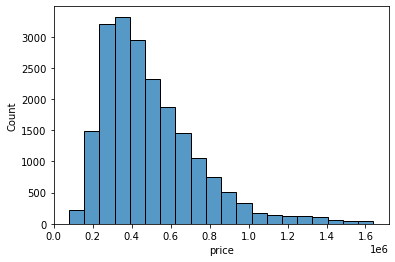

In [ ]:
sns.histplot(df.price, bins=20);

# Feature importance

In [39]:
best[2].head()

,feature,weight
7,sqft_living15,0.177278
82,sqft_living&grade,0.142111
6,sqft_above,0.137537
2,sqft_living,0.127230
5,grade,0.094106


In [51]:
best

LinearRegression()

In [ ]:
sns.barplot(x=best[2]["feature"][:7], y=best[2]["weight"][:7]);

# Pickle best model

In [53]:
with open("model.pkl", "wb") as f:
    pickle.dump(best, f)

In [54]:
# #One hot encode zipcode
# zip_code = df[['zipcode']]
# onehot = OneHotEncoder(sparse=False)
# onehot_data = onehot.fit_transform(zip_code)
# zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
# df = pd.concat([df,zip_code],axis=1)

# Bottom of page. Run GUI loop

In [ ]:
#neccesary?
columns = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade','sqft_above','sqft_living15','sqft_lot15','price']]

In [ ]:
window = Tk()
window.title("my first")
window.configure(background="blue")

In [ ]:
#create header label
Label (window, text="Enter the data:", bg="blue", fg="white", font="none 22 bold") .grid(row=0, column=0, columnspan=2, sticky=W)

In [ ]:
#create input labels
<<<<<<< local
input_labels = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'sqft_lot15', 'age', "zipcode"]
=======
input_labels = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'sqft_lot15', 'age', "zipcode", "months_ago_sold"]
>>>>>>> remote
i=1
for item in input_labels:
    Label (window, text=item, bg="blue", fg="white", font="none 12 bold") .grid(row=i, column=0, sticky=W)
    i+=1

In [ ]:
#create label entry boxes
sqft_living = Entry(window, width=20, bg="white")
sqft_living.grid(row=1, column=1, sticky=W)
grade = Entry(window, width=20, bg="white")
grade.grid(row=2, column=1, sticky=W)
sqft_above = Entry(window, width=20, bg="white")
sqft_above.grid(row=3, column=1, sticky=W)
sqft_living15 = Entry(window, width=20, bg="white")
sqft_living15.grid(row=4, column=1, sticky=W)
bathrooms = Entry(window, width=20, bg="white")
bathrooms.grid(row=5, column=1, sticky=W)
bedrooms = Entry(window, width=20, bg="white")
bedrooms.grid(row=6, column=1, sticky=W)
floors = Entry(window, width=20, bg="white")
floors.grid(row=7, column=1, sticky=W)
sqft_lot = Entry(window, width=20, bg="white")
sqft_lot.grid(row=8, column=1, sticky=W)
sqft_lot15 = Entry(window, width=20, bg="white")
sqft_lot15.grid(row=9, column=1, sticky=W)
age = Entry(window, width=20, bg="white")
age.grid(row=10, column=1, sticky=W)
zipcode = Entry(window, width=20, bg="white")
<<<<<<< local
zipcode.grid(row=11, column=1, sticky=W)
=======
zipcode.grid(row=11, column=1, sticky=W)
months_ago_sold = Entry(window, width=20, bg="white")
months_ago_sold.grid(row=12, column=1, sticky=W)
>>>>>>> remote

In [46]:
#Add submit button
Button (window, text="SUBMIT", width=6, command=click) .grid(row=len(input_labels)+1,column=0, columnspan=2, sticky=W)

In [47]:
#Add another label
Label (window, text="Predicted Price:", bg="black", fg="white", font="none 20 bold") .grid(row=len(input_labels)+2, column=0,sticky=W)

In [48]:
#text output box
output = Text(window, width=75, height=6, wrap=WORD, background="white")
output.grid(row=len(input_labels)+3, column=0, columnspan=2, sticky=W)

In [ ]:
#Run gui loop
window.mainloop()

In [60]:
all_df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade',
       'sqft_above', 'sqft_living15', 'sqft_lot15', 'age', 'months_ago_sold',
       'x0_98001.0', 'x0_98002.0', 'x0_98003.0', 'x0_98004.0', 'x0_98005.0',
       'x0_98006.0', 'x0_98007.0', 'x0_98008.0', 'x0_98010.0', 'x0_98011.0',
       'x0_98014.0', 'x0_98019.0', 'x0_98022.0', 'x0_98023.0', 'x0_98024.0',
       'x0_98027.0', 'x0_98028.0', 'x0_98029.0', 'x0_98030.0', 'x0_98031.0',
       'x0_98032.0', 'x0_98033.0', 'x0_98034.0', 'x0_98038.0', 'x0_98039.0',
       'x0_98040.0', 'x0_98042.0', 'x0_98045.0', 'x0_98052.0', 'x0_98053.0',
       'x0_98055.0', 'x0_98056.0', 'x0_98058.0', 'x0_98059.0', 'x0_98065.0',
       'x0_98070.0', 'x0_98072.0', 'x0_98074.0', 'x0_98075.0', 'x0_98077.0',
       'x0_98092.0', 'x0_98102.0', 'x0_98103.0', 'x0_98105.0', 'x0_98106.0',
       'x0_98107.0', 'x0_98108.0', 'x0_98109.0', 'x0_98112.0', 'x0_98115.0',
       'x0_98116.0', 'x0_98117.0', 'x0_98118.0', 'x0_98119.0', 'x0_98122.0